In [1]:
!pip install matplotlib
!pip install networkx
!pip install tsplib95

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import tsplib95
import itertools as it
import random
from operator import attrgetter

In [3]:
def draw_graph(G):
    pos = nx.circular_layout(G)
    
    nx.draw_networkx_nodes(G, pos,
                           nodelist=[n for n, attr in G.nodes(data=True)],
                           node_color='lightgreen',
                           node_size=300)
    
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    
    labels = nx.get_edge_attributes(G,'distância')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.axis('off')
    plt.title("Exemplo grafo")
    plt.show()

def draw_labeled_multigraph(G, attr_name, ax=None):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 4)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=20, ax=ax)
    nx.draw_networkx_edges(
        G, pos, edge_color="grey", connectionstyle=connectionstyle, ax=ax
    )

    labels = {
        tuple(edge): f"{attr_name}={attrs[attr_name]}"
        for *edge, attrs in G.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        G,
        pos,
        labels,
        connectionstyle=connectionstyle,
        label_pos=0.3,
        font_color="blue",
        bbox={"alpha": 0},
        ax=ax,
    )



[0, 1]


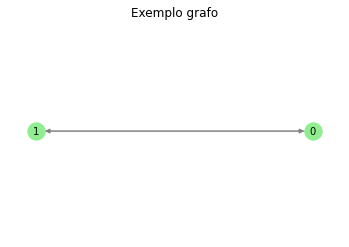

OutMultiEdgeDataView([(0, 1, {'weight': 10}), (1, 0, {'weight': 15})])

In [4]:
# Dados do problema
vertices = [0, 1]
print(vertices)

# Adicionar vértices com atributos
G = nx.MultiDiGraph()  # Grafo direcionado
for i in vertices:
    G.add_node(i)

# Adicionar arestas com atributo de distância
arestas = [
    (0, 1, {"distância": 10}),
    (1, 0, {"distância": 15}),

]
for aresta in arestas:
    G.add_edge(aresta[0], aresta[1], weight=aresta[2]['distância'])
# G.add_edges_from([(e[0], e[1], dict(e[2])) for e in arestas])
# nx.set_edge_attributes(G, {(u, v): d for u, v, d in arestas})
# draw_labeled_multigraph(G, "distância")
# draw_graph(G)

draw_graph(G)
G.edges(data=True)

## CLASSES

In [5]:
def calculate_path_qualitity(G, path):
    qualitity = 0
    for i in range(len(path) - 1):
        node = path[i]
        next_node = path[i + 1]
        qualitity += G[node][next_node][0]['weight']
    # Soma do último cliente visitado para voltar ao depósito
    # qualitity += G[len(path) - 1][0][0]['weight']
    return qualitity

# def get_best_player_qualitity(teams):
#     best_player = None
#     for team in teams:
#         for player in team.players:
#             if best_player == None:
#                 best_player = player
#             elif player.qualitity < best_player.qualitity:
#                 best_player = player
#     return best_player

def get_best_team_qualitity(teams):
    best_team = None
    for team in teams:
        if best_team == None:
            best_team = team
        elif team.qualitity < best_team.qualitity:
            best_team = team
    return best_team

class Player:
    def __init__(self):
        self.path = []
        self.capacity = 0
        self.qualitity = 0

    def set_path(self, path):
        self.path = path
        
    def calculate_qualitity(self, G):
        self.qualitity = calculate_path_qualitity(G, self.path)
        return self.qualitity
        # self.qualitity = 0
        # for i in range(len(self.path) - 1):
        #     node = self.path[i]
        #     next_node = self.path[i + 1]
        #     self.qualitity += G[node][next_node][0]['weight']
        # # Soma do último cliente visitado para voltar ao depósito
        # self.qualitity += G[len(self.path) - 1][0][0]['weight']
        # return self.qualitity

    # def add_node(self, node):
    #     self.nodes.append(node)

class Team:
    def __init__(self):
        self.players = []
        self.captain = None
        self.qualitity = 0
        self.points = 0

    def add_player(self, player):
        self.players.append(player)

    def set_captain(self, player):
        self.captain = player

    def calculate_qualitity(self, G):
        self.qualitity = 0
        for index, player in enumerate(self.players):
            player_qualitity = player.calculate_qualitity(G)
            self.qualitity += player_qualitity
            if index == 0:
                self.captain = player
            elif player_qualitity < self.captain.qualitity:
                self.captain = player
        return self.qualitity

class Table:
    def __init__(self, teams):
        self.teams = teams

    def match(self, team_a, team_b):
        if team_a.qualitity < team_b.qualitity:
            team_a.points += 3
        elif team_b.qualitity < team_a.qualitity:
            team_b.points += 3
        else:
            team_a.points += 1
            team_b.points += 1
    
    def reset(self):
        for team in self.teams:
            team.points = 0

https://link.springer.com/article/10.1007/s10489-013-0512-y
<br>Formato padrão files: http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp95.pdf

## Inicialização do grafo

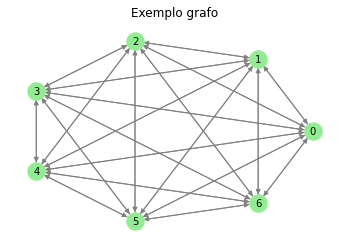

OutMultiEdgeDataView([(0, 0, {'weight': 0}), (0, 1, {'weight': 15}), (0, 2, {'weight': 10}), (0, 3, {'weight': 4}), (0, 4, {'weight': 15}), (0, 5, {'weight': 10}), (0, 6, {'weight': 2}), (1, 0, {'weight': 8}), (1, 1, {'weight': 0}), (1, 2, {'weight': 8}), (1, 3, {'weight': 2}), (1, 4, {'weight': 5}), (1, 5, {'weight': 8}), (1, 6, {'weight': 4}), (2, 0, {'weight': 10}), (2, 1, {'weight': 13}), (2, 2, {'weight': 0}), (2, 3, {'weight': 12}), (2, 4, {'weight': 3}), (2, 5, {'weight': 15}), (2, 6, {'weight': 5}), (3, 0, {'weight': 2}), (3, 1, {'weight': 21}), (3, 2, {'weight': 5}), (3, 3, {'weight': 0}), (3, 4, {'weight': 15}), (3, 5, {'weight': 7}), (3, 6, {'weight': 6}), (4, 0, {'weight': 9}), (4, 1, {'weight': 10}), (4, 2, {'weight': 15}), (4, 3, {'weight': 4}), (4, 4, {'weight': 0}), (4, 5, {'weight': 3}), (4, 6, {'weight': 12}), (5, 0, {'weight': 10}), (5, 1, {'weight': 9}), (5, 2, {'weight': 20}), (5, 3, {'weight': 3}), (5, 4, {'weight': 2}), (5, 5, {'weight': 0}), (5, 6, {'weight': 2}

In [6]:
vehicle_quantity = 2
vehicle_capacity = 3
players_quantity = 2
teams_quantity = 2

# Grafo multi direiconado
G = nx.MultiDiGraph()

matrix = [
    [0, 15, 10, 4, 15, 10, 2],
    [8, 0, 8, 2, 5, 8, 4],
    [10, 13, 0, 12, 3, 15, 5],
    [2, 21, 5, 0, 15, 7, 6],
    [9, 10, 15, 4, 0, 3, 12],
    [10, 9, 20, 3, 2, 0, 2],
    [12, 6, 13, 14, 9, 3, 0],
]

for i in range(len(matrix)):
    for j in range(len(matrix[0])):
        G.add_edge(i, j, weight=matrix[i][j])

draw_graph(G)
G.edges(data=True)

## Fase de Inicialização
Trabalho com técnica: https://ieeexplore.ieee.org/document/7550764
<br>
The first step is the creation of a set of solutions, called P,
which will make up the initial population. All solutions are
created randomly and they are called player (pi).

In [28]:
# Inicialização e divisão dos jogadores em times
teams = []
for i in range(0, teams_quantity):
    team = Team()
    teams.append(team)
    nodes_available = list(G)
    nodes_available.pop(0) # Remoção do nodo depósito
    for j in range(0, players_quantity):
        player = Player()
        team.add_player(player)
        path = [0]
        while player.capacity < vehicle_capacity:
            node = random.choice(nodes_available)
            nodes_available.remove(node)
            path.append(node)
            player.capacity += 1
        path.append(0)
        player.path = path

# Visualização
for index, team in enumerate(teams):
    print(f"Time {index} | Qualidade {team.calculate_qualitity(G)} | Capitão {team.captain.qualitity}")
    for player in team.players:
        print(player.path)
        print(f"Qualidade: {player.calculate_qualitity(G)}")


Time 0 | Qualidade 80 | Capitão 39
[0, 2, 3, 5, 0]
Qualidade: 39
[0, 4, 1, 6, 0]
Qualidade: 41
Time 1 | Qualidade 59 | Capitão 17
[0, 2, 5, 1, 0]
Qualidade: 42
[0, 6, 4, 3, 0]
Qualidade: 17


## Competição
### Funções

In [29]:
# Realiza a escolha aleatória de um elemento da lista com exceção do valor passado
def choice_excluding(lst, exceptions):
    possible_choices = [v for v in lst if v not in exceptions]
    return random.choice(possible_choices)
    
# Realiza a troca de forma randômica entre dois clientes de diferentes 
def swap_move(player_a, player_b):
    new_path_a = player_a.path[:]
    new_path_b = player_b.path[:]
    node_path_a = choice_excluding(new_path_a, [0])
    node_path_b = choice_excluding(new_path_b, [0])
    index_a = new_path_a.index(node_path_a)
    index_b = new_path_b.index(node_path_b)
    # TODO: Verificar capacidade do veículo para o novo caminho
    new_path_a[index_a] = node_path_b
    new_path_b[index_b] = node_path_a
    qualitity_path_a = calculate_path_qualitity(G, new_path_a)
    qualitity_path_b = calculate_path_qualitity(G, new_path_b)
    # TODO: Verificar nos testes se não é melhor trocar os caminhos independente da qualidade final (remover condição)
    # TODO: Verificar se apenas com 1 caminho sendo melhor deve-se trocar ainda assim
    if qualitity_path_a < player_a.qualitity and qualitity_path_b < player_b.qualitity:
        print("Mudou path swap_move")
        player_a.path = new_path_a
        player_b.path = new_path_b
        return True
    return False

# Realiza a troca da posição de forma randômica entre dois clientes de uma mesma rota.
def shift_move(player):
    new_path = player.path[:]
    random_node_1 = choice_excluding(new_path, [0])
    random_node_2 = choice_excluding(new_path, [0, random_node_1])
    index_1 = new_path.index(random_node_1)
    index_2 = new_path.index(random_node_2)
    # TODO: Verificar capacidade do veículo para o novo caminho
    new_path[index_1] = random_node_2
    new_path[index_2] = random_node_1
    qualitity_path = calculate_path_qualitity(G, new_path)
    if qualitity_path < player.qualitity:
        print("Mudou path shift_move")
        player.path = new_path
        return True
    return False
    


In [33]:

# Partidas entre os times
def match_playing(teams):
    for i, team in enumerate(teams):
        for j in range(i+1, len(teams)):
            table.match(team, teams[j])

def sort_teams_by_points(teams):
    return sorted(teams, key=attrgetter('points'), reverse=True)

def sort_players_by_qualitity(players):
    return sorted(players, key=attrgetter('qualitity'))

# def transfer_teams(teams):
#     teams_ordered = sort_teams_by_points(teams)
#     for i in range(int(len(teams_ordered) / 2)):
#         team_a = teams_ordered[i]
#         team_b = teams_ordered[len(teams_ordered) - i - 1]
#         print(team_a)
#         print(team_b)

def transfer_teams(teams):
    teams_ordered = sort_teams_by_points(teams)
    for i in range(int(len(teams_ordered) / 2)):
        team_a = teams_ordered[i]
        team_b = teams_ordered[i + 1]
        team_a_players_ordered = sort_players_by_qualitity(team_a.players)
        team_b_players_ordered = sort_players_by_qualitity(team_b.players)
        team_a_worse_player = team_a_players_ordered[len(team_a_players_ordered) - 1]
        team_b_best_player = team_b_players_ordered[0]
        team_a_worse_player.path = team_b_best_player.path
        
        # Verificar valores diferentes entre o worse e best player
        
        
        for player in team_a.players:
            # Não é o mesmo player
            if player != team_a_worse_player:
                for i in player.path:
                    pass
                

        
transfer_teams(teams)

print(teams[0].players[0].path)



b
a
[0, 2, 3, 5, 0]


In [22]:
table = Table(teams)

first_best_team = get_best_team_qualitity(teams)
print("Best first team:", first_best_team.qualitity)

for i in range(1000):
    pass
    table.reset()
    # Período de treinamento
    for team in teams:
        player_a = random.choice(team.players)
        player_b = random.choice(team.players)
        while player_b == player_a:
            player_b = random.choice(team.players)
        if swap_move(player_a, player_b):
            team.calculate_qualitity(G)
        player = random.choice(team.players)
        if shift_move(player):
            team.calculate_qualitity(G)
    # Período de competição
    match_playing(teams)
    # Período de transferência
#     transfer_teams(teams)
    # match_playing(teams)


new_best_team = get_best_team_qualitity(teams)
print("Best new team:", new_best_team.qualitity)
for player in new_best_team.players:
    print(player.path)

Best first team: 46
Best new team: 46
[0, 6, 5, 4, 0]
[0, 3, 2, 1, 0]
